In [42]:
import pandas as pd
import pandas_profiling

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

#データ読み込み
train_df = pd.read_csv("data/train_df.csv")
test_df = pd.read_csv("data/test_df.csv")
sample= pd.read_csv("data/submission.csv",header = None)

In [43]:
# Object型変数をLabel Encoding

# Object型変数をリストで取得
categories = train_df.columns[train_df.dtypes=='object'].values.tolist()

# Label Encoding実施
for cat in categories:
    train_df[cat].fillna('unknown', inplace=True)
    test_df[cat].fillna('unknown', inplace=True)
    
    le_train = LabelEncoder()
    le_train = le_train.fit(train_df[cat])
    # Encoding
    train_df[cat] = le_train.transform(train_df[cat])
    test_df[cat] = le_train.transform(test_df[cat])
    
    # Category型に変換
    train_df[cat] = train_df[cat].astype('category')
    test_df[cat] = test_df[cat].astype('category')

In [44]:
train_df['target'] = 0
test_df['target'] = 1 

df = pd.concat([train_df, test_df], axis=0)
df.head()

,id,personal_id_1,personal_id_2,facility_id,age,bmi,situation_1,situation_2,ethnicity,gender,...,diabetes,hepatic_issue,immunosuppression,leukemia,lymphoma,carcinoma,body_system_1,body_system_2,target_label,target
0,0,114501,58009,51,69.0,24.731460,0,1.0,2,1,...,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0
1,1,44353,112590,19,64.0,28.666129,0,1.0,2,1,...,0.0,0.0,0.0,0.0,0.0,0.0,11,10,0.0,0
2,2,8023,1677,16,74.0,18.144869,0,0.0,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.0,0
3,3,106340,74166,188,60.0,23.047667,0,0.0,2,1,...,1.0,0.0,0.0,0.0,0.0,0.0,5,3,0.0,0
4,4,118467,52717,168,75.0,20.190265,0,0.0,2,0,...,0.0,0.0,0.0,0.0,0.0,1.0,1,1,0.0,0


In [45]:
train_df.columns

Index(['id', 'personal_id_1', 'personal_id_2', 'facility_id', 'age', 'bmi',
       'situation_1', 'situation_2', 'ethnicity', 'gender', 'height', 'weight',
       'icu_id', 'icu_1', 'icu_2', 'icu_3', 'icu_4', 'icu_5', 'icu_6', 'icu_7',
       'icu_8', 'glasgow_coma_scale_1', 'glasgow_coma_scale_2',
       'glasgow_coma_scale_3', 'glasgow_coma_scale_4', 'heart_rate',
       'blood_oxy', 'arterial_pressure', 'respiratory_rate', 'temp',
       'blood_pressure_1', 'blood_pressure_2', 'blood_pressure_3',
       'blood_pressure_4', 'v1_heartrate_max', 'v2', 'v3', 'v4', 'v5', 'v6',
       'v7', 'v8', 'v9', 'v10', 'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'w1',
       'w2', 'w3', 'w4', 'w5', 'w6', 'w7', 'w8', 'w9', 'w10', 'w11', 'w12',
       'w13', 'w14', 'w15', 'w16', 'w17', 'w18', 'x1', 'x2', 'x3', 'x4', 'x5',
       'x6', 'aids', 'cirrhosis', 'diabetes', 'hepatic_issue',
       'immunosuppression', 'leukemia', 'lymphoma', 'carcinoma',
       'body_system_1', 'body_system_2', 'target_label'

In [37]:
from sklearn.model_selection import train_test_split
import lightgbm as lgb

y_all = df['target']
x_all = df.drop(['target', 'id', 'target_label'], axis=1)

x_all

,personal_id_1,personal_id_2,facility_id,age,bmi,situation_1,situation_2,ethnicity,gender,height,...,aids,cirrhosis,diabetes,hepatic_issue,immunosuppression,leukemia,lymphoma,carcinoma,body_system_1,body_system_2
0,114501,58009,51,69.0,24.731460,0,1.0,2,1,175.30,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0
1,44353,112590,19,64.0,28.666129,0,1.0,2,1,183.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11,10
2,8023,1677,16,74.0,18.144869,0,0.0,2,0,166.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
3,106340,74166,188,60.0,23.047667,0,0.0,2,1,182.90,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5,3
4,118467,52717,168,75.0,20.190265,0,0.0,2,0,160.02,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12835,79880,56511,19,39.0,23.147277,0,0.0,2,0,163.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
12836,97405,32055,136,79.0,27.759515,0,0.0,2,1,175.50,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
12837,31970,117733,70,56.0,28.331661,0,1.0,2,0,172.70,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,4
12838,76051,93359,189,79.0,24.578812,0,1.0,0,0,170.20,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1


/usr/local/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categori

[10]	training's auc: 0.626135	training's binary_logloss: 0.494061	valid_1's auc: 0.494045	valid_1's binary_logloss: 0.501133
[20]	training's auc: 0.675437	training's binary_logloss: 0.488183	valid_1's auc: 0.495417	valid_1's binary_logloss: 0.501701

auc(train_data) = 0.5177
auc(valid_data) = 0.5040



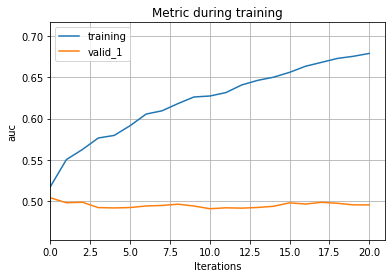

/usr/local/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categori

[10]	training's auc: 0.632512	training's binary_logloss: 0.493777	valid_1's auc: 0.490019	valid_1's binary_logloss: 0.501102
[20]	training's auc: 0.690011	training's binary_logloss: 0.48756	valid_1's auc: 0.492712	valid_1's binary_logloss: 0.501624

auc(train_data) = 0.5207
auc(valid_data) = 0.4963



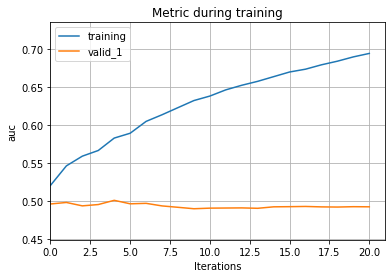

/usr/local/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categori

[10]	training's auc: 0.621292	training's binary_logloss: 0.494143	valid_1's auc: 0.495419	valid_1's binary_logloss: 0.500979
[20]	training's auc: 0.677611	training's binary_logloss: 0.488259	valid_1's auc: 0.497728	valid_1's binary_logloss: 0.501473

auc(train_data) = 0.5370
auc(valid_data) = 0.4981



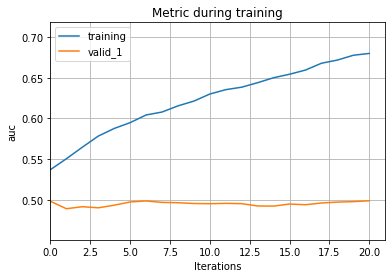

/usr/local/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categori

[10]	training's auc: 0.620642	training's binary_logloss: 0.494081	valid_1's auc: 0.498861	valid_1's binary_logloss: 0.500976
[20]	training's auc: 0.666575	training's binary_logloss: 0.488346	valid_1's auc: 0.498351	valid_1's binary_logloss: 0.501466

auc(train_data) = 0.5232
auc(valid_data) = 0.4993



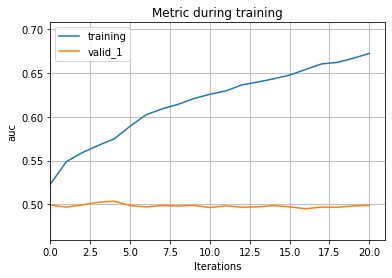

/usr/local/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categori

[10]	training's auc: 0.629787	training's binary_logloss: 0.494085	valid_1's auc: 0.49093	valid_1's binary_logloss: 0.501043
[20]	training's auc: 0.677523	training's binary_logloss: 0.48842	valid_1's auc: 0.494992	valid_1's binary_logloss: 0.501076

auc(train_data) = 0.5410
auc(valid_data) = 0.5003



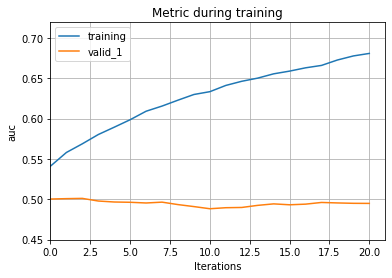

In [38]:
lgbm_params = {
    'boosting_type': 'gbdt',        # Gradient Boosting Decision Tree
    'objective': 'binary',          # 2値分類
    'metric': 'auc',                # 評価指標
    'learning_rate': 0.1,           # Adversarial-testing場合、lr = 0.05〜0.1で十分です。

    'random_seed': 42               # 乱数設定です。 お好きな数字をどうぞ。
}

folds = 5      # Adversarial testingでは、５で十分と思います。
models = []
auc = []
imp_df = pd.DataFrame()
cv = list(StratifiedKFold(n_splits=folds, shuffle=True, random_state=42).split(x_all, y_all))

for n_fold in np.arange(folds):
    
    # fold毎の訓練データのindexを取得
    train_index = cv[n_fold][0]
    # fold毎の検証データのindexを取得
    valid_index = cv[n_fold][1]
    # fold毎の訓練データの説明変数を用意
    x_train_cv = x_all.iloc[train_index]
    # fold毎の訓練データの目的変数を取得
    y_train_cv = y_all.iloc[train_index]
    # fold毎の検証データの説明変数を用意
    x_valid_cv = x_all.iloc[valid_index]
    # fold毎の検証データの目的変数を取得
    y_valid_cv = y_all.iloc[valid_index]
    
    model = lgb.LGBMClassifier(n_estimators=1000, random_state=42)
    model.fit(
        x_train_cv, 
        y_train_cv,
        eval_metric='auc',
        eval_set = [(x_train_cv, y_train_cv), (x_valid_cv, y_valid_cv)], 
        early_stopping_rounds = 20,            # Adversarial-testingでは、20~50もあれば十分と思います。
        categorical_feature = categories, 
        
        verbose = 10, 
    )
    
    y_pred_train = model.predict_proba(x_train_cv, num_iteration=model.best_iteration_)[:, 1]
    y_pred_valid = model.predict_proba(x_valid_cv, num_iteration=model.best_iteration_)[:, 1]
    
    # AUCの算出
    # 学習用データ
    temp_auc_train = roc_auc_score(y_train_cv, y_pred_train)
    
    # 検証用データ
    temp_auc_valid = roc_auc_score(y_valid_cv, y_pred_valid)
    
    # AUCの表示
    print(f'\nauc(train_data) = {temp_auc_train:.4f}')
    print(f'auc(valid_data) = {temp_auc_valid:.4f}\n')
    
    # AUCをリストにappend
    auc.append([temp_auc_train, temp_auc_valid])

    # 学習済みモデルをリストにappend
    models.append(model)
        
    # 各fold毎に、学習済みモデルによる特徴量重要度（スコア）を算出し、DF化
    temp_imp = pd.DataFrame({
        'col': x_all.columns, 
        'imp': model.feature_importances_
    })
    
    
    # 上記、生成されたDFを、concatしていく
    imp_df = pd.concat(
        [imp_df, temp_imp], 
        axis=0, 
        ignore_index=True
    )
    
    
    # 各fold毎に、学習状況（AUC）を可視化
    lgb.plot_metric(model, metric='auc');
    plt.show();

In [39]:
# aucのNumPy配列化
auc_np = np.array(auc)

# 学習データのpredictに対する、平均auc
auc_train_mean = auc_np[:, 0].mean()
print(f'auc(train_data)_mean = {auc_train_mean:.4f}')

# 検証データのpredictに対する、平均auc
auc_valid_mean = auc_np[:, 1].mean()
print(f'auc(valid_data)_mean = {auc_valid_mean:.4f}')

auc(train_data)_mean = 0.5279
auc(valid_data)_mean = 0.4996


In [40]:
# 説明変数の重要度を整形
imp_group_df = imp_df.groupby('col')['imp'].agg(['mean', 'std'])

# カラム名の変更
imp_group_df.columns = ['imp_mean', 'imp_std']

# indexをリセット
imp_group_df = imp_group_df.reset_index(drop=False)

# imp_meanでソート
imp_group_df.sort_values('imp_mean', ascending=False, ignore_index=True).loc[0:50, :]

,col,imp_mean,imp_std
0,age,1.4,1.140175
1,personal_id_2,1.4,1.673320
2,bmi,1.4,0.547723
3,x2,1.2,0.836660
4,v2,1.2,0.447214
5,arterial_pressure,1.0,0.707107
6,v11,1.0,1.000000
7,w6,1.0,0.707107
8,x3,0.8,0.836660
9,facility_id,0.8,0.836660


"""
仮に、分布差異が確認された時には、上記の「特徴量の重要度スコア」が有用です。 一番シンプルな対処法は、「重要度が高い変数（モデルが訓練用データと予測対象用データの分類に役立てた変数）」から、順に、削除していく事です。

AUC=0.6〜0.7あたりまで、重要度が高い特徴量を削除していく人もいます。 ただ、その場合、モデルの学習に使用できる変数が減っていくので、検証データのスコアも通常は悪化していくというトレードオフの関係になります。
"""

AUCスコアの高い訓練データを抽出し、それを検証データとする」（これが、Adversarial-validationです）方法があります。

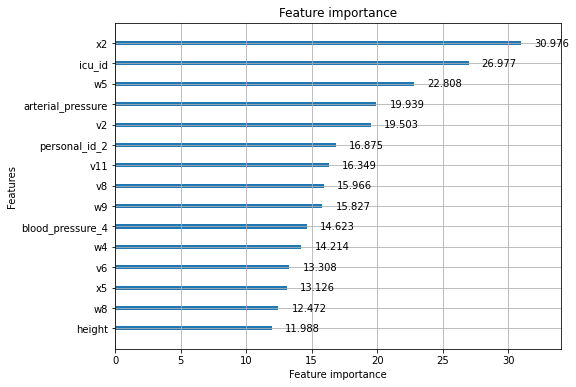

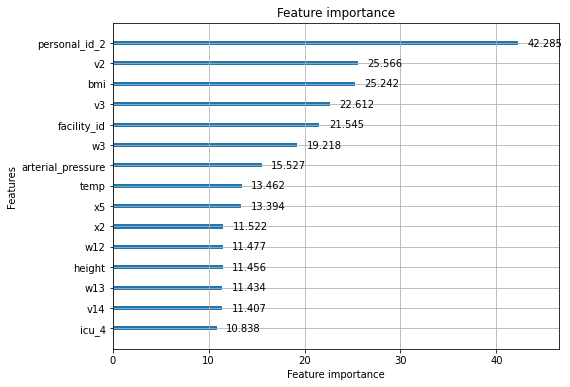

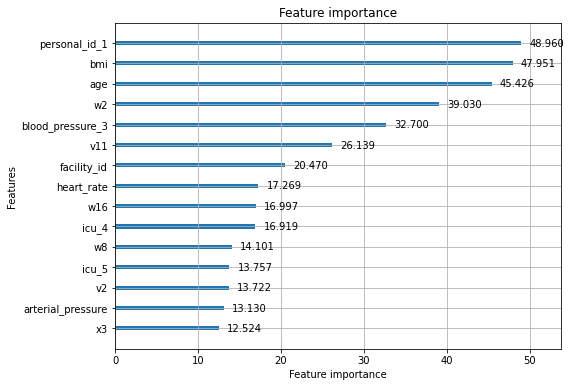

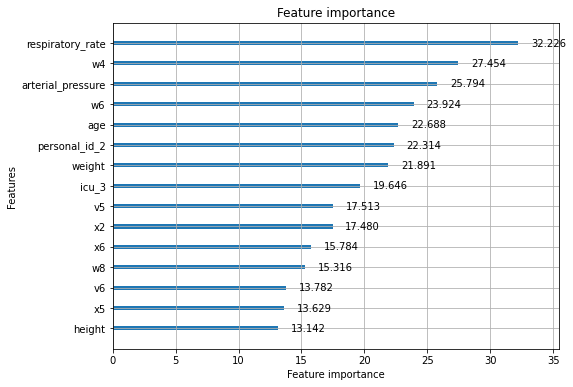

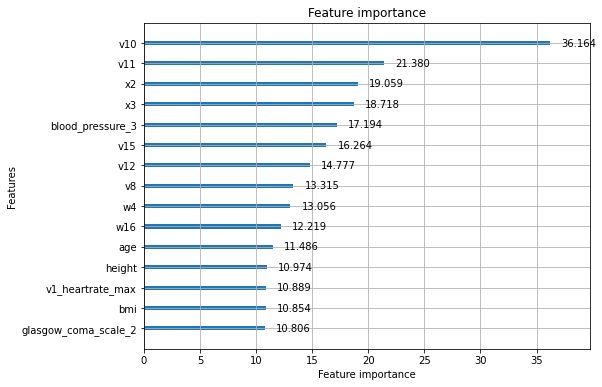

In [41]:
for model in models:
    
    lgb.plot_importance(model, importance_type='gain', max_num_features=15, figsize=(8, 6));